In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import inflection
import spellchecker
from tqdm import tqdm
import nltk
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','please','are'])

In [3]:
# Import Dataset
df = pd.read_excel('/Users/s0c02nj/Desktop/adhoc_reroute.xlsx')
#print(df.target_names.unique())
df.head()

,quoteid,purchasecmpny,dept,reroutersncode,reroutersntxt,reroutecmnt,reroutelastchngts
0,12803160,1001,22,4,Inaccurate Product Format,Inaccurate Product Format; 29Jun2019 TT. The w...,2019-11-04 10:15:31.0
1,12935402,1001,3,11,Incomplete/Inaccurate Value Breakdown,Incomplete/Inaccurate Value Breakdown; Compone...,2019-11-04 10:05:03.0
2,12617809,1001,63,13,IPR Concern,IPR Concern; change pkging desc to emeril,2019-11-04 09:53:31.0
3,12617809,1001,63,13,IPR Concern,IPR Concern; Change Packaging Description from...,2019-11-04 09:53:31.0
4,12617809,1001,63,4,Inaccurate Product Format,Inaccurate Product Format; A second HTS line n...,2019-11-04 09:53:31.0


In [4]:
#Removing the concern area
df['reroutecmnt'] = df['reroutecmnt'].astype(str)
cln_list1 = []

for i in tqdm(range(0,len(df))):
    text_to_rmv = df['reroutersntxt'].iloc[i] + ';'
    cln_list1.append(re.sub(text_to_rmv,'',df['reroutecmnt'].iloc[i]))
    

100%|██████████| 18575/18575 [00:00<00:00, 38175.01it/s]


In [5]:
df['reroutecmnt_cln'] =  cln_list1

In [6]:
def text_preprocessing(text):
    #d = enchant.Dict("en_US")
    text= text.lower()
    text= re.sub(r'[^a-z]',' ',text)
    text= " ".join([s for s in text.split() if len(s)>2])
    #text = drop_duplicates(text)
    text= " ".join([x for x in text.split() if x not in stop_words])
    text= " ".join([inflection.singularize(x) for x in text.split()])
    text= ' '.join(text.split())
    return(text)

In [7]:
def RemoveSpecialCharacters(doc):
    return re.sub('\W+',' ', str(doc)).strip().lower()

date_formats = r'''\d?\d/\d\d?/\d?\d?\d\d|
                   (\d?\d)\s*(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s*(\d\d\d\d)| 
                   \d?\d-\d?\d-\d?\d?\d\d|
                   \d\d\.\d\d\.\d\d|
                   (jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s*(\d\d\d\d)'''
re_date = re.compile(date_formats,re.VERBOSE)

def RemoveDate(x):
    return re_date.sub('',x)

In [8]:
df['reroutecmnt_cln']  = df['reroutecmnt_cln'].apply(RemoveSpecialCharacters)
df['reroutecmnt_cln'] = df['reroutecmnt_cln'].apply(RemoveDate)


#### Separating Sentences from each of the documents

In [9]:
concern = 'Inaccurate Product Format'
df_sub  = df[df['reroutersntxt'] == concern]

In [66]:
list_comb = []

for i in tqdm(range(0,len(df_sub))):
    temp = df_sub['reroutecmnt_cln'].iloc[i]
    list_temp = list(filter(None, temp.split('.')))
    list_comb = list_comb + list_temp

100%|██████████| 1871/1871 [00:00<00:00, 35189.67it/s]


In [78]:
list_comb[10]

'please remove the duplicate long nose plier line'

In [75]:
df_new = pd.DataFrame()
df_new['comments'] = df_sub['reroutecmnt_cln']

In [12]:
cln_lst2 = []
for i in tqdm(range(0,len(df_new))):
    text = df_new['comments'].iloc[i]
    
    #Clean
    cln_lst2.append(text_preprocessing(text))
    

100%|██████████| 1871/1871 [00:01<00:00, 1859.48it/s]


In [13]:
df_new['comments'] = cln_lst2

In [79]:
spell = spellchecker.SpellChecker()

In [ ]:
#df = get_spell_corr(df,'comments')
def get_spell_corr(word):
    
    new_word = " ".join([spell.correction(y) for y in word.split()])
    
    return new_word

In [ ]:
cln_lst3 = []

for i in tqdm(range(0,len(df_new))):
    
    word = df_new['comments'].iloc[i]
    cln_lst3.append(get_spell_corr(word))

In [ ]:
#df_new['comments'] = cln_lst3

In [ ]:
#df.to_csv('/Users/s0c02nj/Desktop/Inaccurate_Product_Format.csv',index = False)

In [ ]:
df_new

#### Word_Vectors based approach

In [14]:
folder_path= '/Users/s0c02nj/Downloads/glove.6B/glove.6B.100d.txt'
f=open(folder_path)
doc=f.readlines()
#****VIP
#**WORD TO VEC DICTIONARY
#Forming a dictionary-word2vec
word2vec={}
key=[]
#looping though the doc.in the doc the entire thing is saved and is separated by a space bar.
for line in tqdm(doc):
    #parts contains every word separately for doc1
    parts=line.split(' ')
    #part[0] contains the word
    word=parts[0]
    key.append(word)
    #embed contains the vector
    embed=np.array(parts[1:],dtype='float32')
    #filling up the dictionary
    word2vec[word]=embed


100%|██████████| 400000/400000 [00:08<00:00, 45559.67it/s]


In [15]:
df_new['comments_ls'] = df_new['comments'].apply(lambda x:x.split())

In [46]:
df_new['ind'] = df_new['comments_ls'].apply(lambda x : 1 if len(x)==0 else 0)

In [48]:
df_new = df_new[df_new['ind'] == 0]
df_new.shape

(1833, 3)

In [ ]:
# from gensim.models import Word2Vec
# sentences = df_new['comments_ls'].to_list()
# model = Word2Vec(sentences, min_count=1, size=300)
# vocab = model.wv.vocab.keys()
# wordsInVocab = len(vocab)

In [49]:
def sent_vectorizer(sent, word2vec):
    sent_vec = np.zeros(100)
    numw = 0
    for w in sent:
        try:
            sent_vec = np.add(sent_vec, word2vec[w])
            numw+=1
        except:
            pass
    return sent_vec/(numw+1)

In [50]:
ls_vec = []

for i in tqdm(range(0,len(df_new))):
    
    sent = df_new['comments_ls'].iloc[i]
    vec = sent_vectorizer(sent, word2vec)
    
    ls_vec.append(vec)
              

100%|██████████| 1833/1833 [00:00<00:00, 8629.74it/s]


In [51]:
ls_vec = np.array(ls_vec)
ls_vec.shape

(1833, 100)

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [93]:
corpus = df_new['comments'].to_list()

In [94]:
vectorizer = TfidfVectorizer( ngram_range=(1, 3),stop_words='english',max_features = 1000)

In [95]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [96]:
X1 = X.toarray()

In [97]:
from sklearn.decomposition import PCA

In [101]:
pca = PCA(n_components=300)

In [102]:
X2 = pca.fit_transform(X1)  

In [103]:
pca.explained_variance_ratio_.sum()

0.8407408454682457

In [119]:
#pd.DataFrame(X2).describe()

In [105]:
from sklearn.cluster import KMeans

In [108]:
kmeans = KMeans(n_clusters=5, random_state=10).fit(X2)

In [109]:
df_new['clus_centre'] = kmeans.labels_

In [110]:
df_new['clus_centre'].value_counts()

1    1050
3     617
2      73
0      71
4      60
Name: clus_centre, dtype: int64

In [114]:
df_clust1 = df_new[df_new['clus_centre'] == 1]

In [115]:
list_clust1 = []
for i in range(0,len(df_clust1)) :
    sent = df_clust1['comments'].iloc[i]
    token = nltk.word_tokenize(sent)
    bigrams = ngrams(token,2)
    
    list_clust1.extend(list(bigrams))

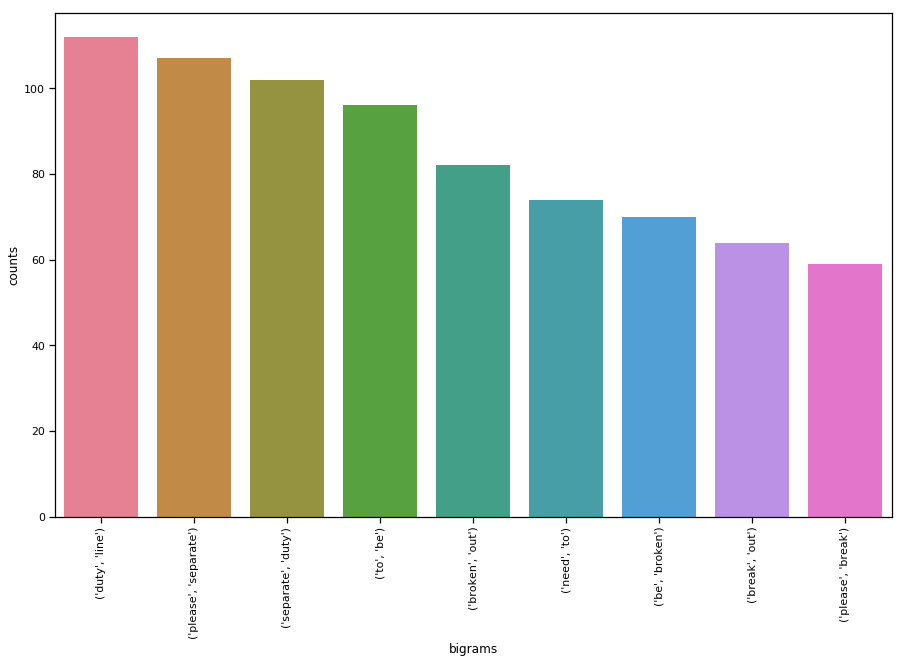

In [118]:
c = Counter(list_clust1) 

import operator
sorted_x = sorted(c.items(), key=operator.itemgetter(1),reverse=True)
bi_grams = pd.DataFrame(sorted_x)

plt.figure(2, figsize=(15, 15/1.6180))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
sns.barplot(bi_grams.iloc[1:10,0],bi_grams.iloc[1:10,1],palette='husl')
plt.xticks(rotation=90)
plt.xlabel('bigrams')
plt.ylabel('counts')
plt.show()

In [87]:
c.items()

dict_items([(('second', 'ht'), 2), (('ht', 'line'), 25), (('line', 'need'), 9), (('need', 'added'), 8), (('added', 'nonskid'), 2), (('nonskid', 'mat'), 2), (('appear', 'item'), 1), (('item', 'broken'), 3), (('broken', 'two'), 1), (('two', 'product'), 1), (('product', 'however'), 1), (('however', 'item'), 2), (('item', 'associated'), 1), (('associated', 'product'), 1), (('product', 'also'), 1), (('also', 'help'), 1), (('help', 'provide'), 1), (('provide', 'additional'), 1), (('additional', 'picture'), 2), (('picture', 'side'), 1), (('side', 'garment'), 1), (('supplier', 'need'), 2), (('need', 'create'), 4), (('create', 'template'), 1), (('remove', 'belden'), 2), (('belden', 'park'), 2), (('park', 'piece'), 2), (('piece', 'leisure'), 2), (('leisure', 'set'), 2), (('set', 'red'), 2), (('combine', 'extension'), 1), (('extension', 'bar'), 1), (('bar', 'ratcheting'), 1), (('ratcheting', 'screwdriver'), 1), (('screwdriver', 'component'), 1), (('component', 'since'), 1), (('since', 'appear'), 

In [91]:
#sorted_x = sorted(c.items(), key=operator.itemgetter(1),reverse=True)


In [90]:
#sorted_x

In [ ]:
sns.countplot(df_new['clus_centre'])
